# Семантическая Сегментация. Часть 3.

## Переключение версии TensorFlow

In [1]:
# %tensorflow_version 2.x

In [2]:
import os
import skimage.io as io
import numpy as np

import tensorflow as tf
# from tensorflow_examples.models.pix2pix import pix2pix
# import tensorflow_datasets
# pix2pix = tensorflow_datasets.load('pix2pix')

## Загрузка датасета COCO и COCO API

In [3]:
if 0:
    !mkdir data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

In [4]:
!pip install pycocotools

## Подготовка COCO API

In [5]:
COCO_ROOT = './data/'
# import sys
# sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [6]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [7]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [8]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=18.84s)
creating index...
index created!
loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


In [9]:
# train_ds = COCO_dataset_train.train_dataset(...)
# val_ds = COCO_dataset_val.val_dataset(...)

In [10]:
INP_SIZE = 128
NUM_EPOCHS = 1
BATCH_SIZE = 32

train_ds = COCO_dataset_train.train_dataset(BATCH_SIZE, NUM_EPOCHS, INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(BATCH_SIZE, INP_SIZE)

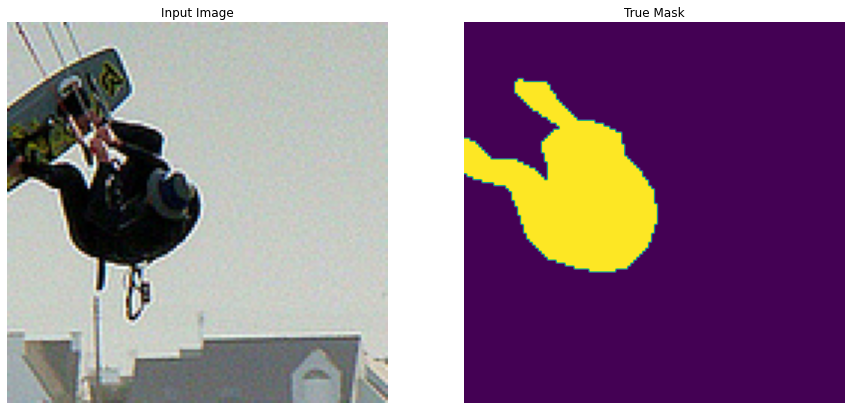

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for image, mask in val_ds.take(1):
    sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

In [16]:
def build_model():
    x = tf.keras.layers.Input((128, 128, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [13]:
# BATCH_SIZE = 1

# loss = tf.keras.losses.BinaryCrossentropy()
# model.compile(optimizer='adam', loss=loss)

# hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=val_ds)

# plt.plot(hist.history['loss'])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [36]:
# !pip install pydot

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [38]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

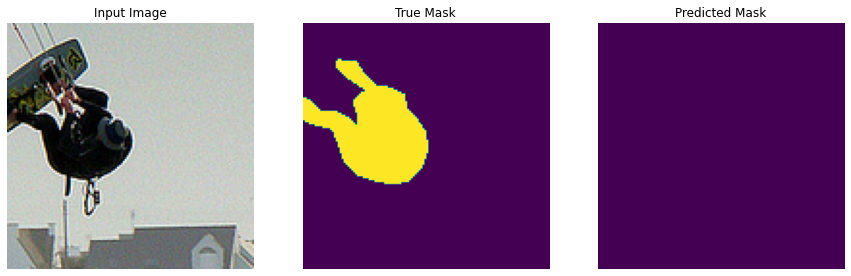

In [40]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

In [41]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [42]:
%%time
with tf.device('/device:CPU:0'):
    history_model = model.fit(
        train_ds,
        epochs=NUM_EPOCHS,
        validation_data=val_ds,
        callbacks=[DisplayCallback()]
    ).history

1714/2003 [========================>.....] - ETA: 40:32 - loss: 0.4715 - accuracy: 0.7928

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

1715/2003 [========================>.....] - ETA: 40:24 - loss: 0.4715 - accuracy: 0.7928

UnknownError:  ImportError: numpy.core.multiarray failed to import
Traceback (most recent call last):

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-7-54e7e9bf8410>", line 14, in read_images
    img = io.imread(os.path.join(COCO_ROOT, img_fname))

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\skimage\io\_io.py", line 53, in imread
    img = call_plugin('imread', fname, plugin=plugin, **plugin_args)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\skimage\io\manage_plugins.py", line 207, in call_plugin
    return func(*args, **kwargs)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\skimage\io\_plugins\imageio_plugin.py", line 10, in imread
    return np.asarray(imageio_imread(*args, **kwargs))

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\imageio\core\functions.py", line 160, in imread
    return file.read(index=0, **kwargs)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\imageio\core\legacy_plugin_wrapper.py", line 130, in read
    return reader.get_data(index)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\imageio\core\format.py", line 340, in get_data
    im, meta = self._get_data(index, **kwargs)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\imageio\plugins\gdal.py", line 68, in _get_data
    return self._ds.ReadAsArray(), self._get_meta_data(index)

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\osgeo\gdal.py", line 2282, in ReadAsArray
    from osgeo import gdal_array

  File "c:\users\ifl\documents\github\.venv\lib\site-packages\osgeo\gdal_array.py", line 13, in <module>
    from . import _gdal_array

ImportError: numpy.core.multiarray failed to import


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_6248]

Function call stack:
train_function


In [ ]:
model.evaluate(val_ds)

In [ ]:
loss = history_model['loss']
val_loss = history_model['val_loss']

epochs = range(NUM_EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
for image, mask in val_ds.take(5):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])